# Reference: 
### https://github.com/rakeshranjan001/Movie-Recommendation-System-Collaborative-filtering-MovieLens-100k-/blob/master/Python%20Code.py

In [115]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine, correlation
import matplotlib.pyplot as plt
import random

from sklearn.metrics import mean_squared_error
from surprise import accuracy

from numpy import count_nonzero
import progressbar as pb
import math

In [17]:
#Loading movielens data
#Ratings
rating_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('data_files/u.data', sep='\t', names=rating_cols)

#Movies
movie_cols = ['movie_id', 'title', 'release_date', 'video_release_date', 'imdb_url', "unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"]
movies = pd.read_csv('data_files/u.item', sep='|', names=movie_cols, encoding='latin-1')

In [18]:
movies

,movie_id,title,release_date,video_release_date,imdb_url,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1678,1679,B. Monkey (1998),06-Feb-1998,NaN,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1679,1680,Sliding Doors (1998),01-Jan-1998,NaN,http://us.imdb.com/Title?Sliding+Doors+(1998),0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1680,1681,You So Crazy (1994),01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?You%20So%20Cr...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
genre = []
for index, row in movies.iterrows():
    tmp = []
    n = 0
    for d in row:
        if d == 1:
            tmp.append(movie_cols[n])
        n=n+1
    if 'movie_id' in tmp:
        tmp.remove('movie_id')
    genre.append('|'.join(tmp))

In [20]:
movies.insert(loc=5, column='genres', value=genre)
movies.drop(["video_release_date","unknown", "Action", "Adventure", "Animation", "Children's",
"Comedy", "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir","Horror", "Musical", " Mystery", "Romance", "Sci-Fi", "Thriller",
"War","Western"], axis='columns', inplace=True)

In [21]:
movies

,movie_id,title,release_date,imdb_url,genres
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy
1,2,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,Action|Adventure|Thriller
2,3,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,Thriller
3,4,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,Action|Comedy|Drama
4,5,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),Crime|Drama|Thriller
...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy


In [22]:
#Merging movie data with their ratings
movie_ratings = pd.merge(movies, ratings)

In [26]:
movie_ratings

,movie_id,title,release_date,imdb_url,genres,user_id,rating,timestamp
0,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,308,4,887736532
1,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,287,5,875334088
2,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,148,4,877019411
3,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,280,4,891700426
4,1,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,Animation|Children's|Comedy,66,3,883601324
...,...,...,...,...,...,...,...,...
99995,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama,863,1,889289570
99996,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller,863,3,889289491
99997,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance,863,2,889289570
99998,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy,896,3,887160722


In [122]:
movie_ratings.to_csv('data_files/sorted_movie_data.csv')

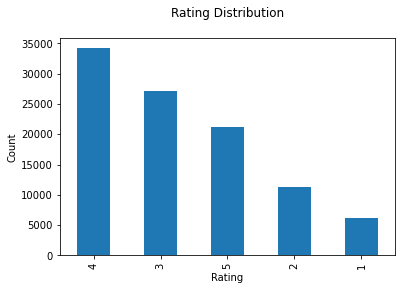

In [27]:
plt.rc("font", size=10)
movie_ratings.rating.value_counts(sort=True).plot(kind='bar')
plt.title("Rating Distribution\n")
plt.xlabel('Rating')
plt.ylabel('Count')
# plt.savefig('system1.png', bbox_inches='')
plt.show()

In [90]:
#Pivot Table(This creates a matrix of users and movie_ratings)
ratings_matrix = ratings.pivot_table(index=['movie_id'],columns=['user_id'],values='rating').reset_index(drop=True)
ratings_matrix.fillna( 0, inplace = True )

In [91]:
ratings_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [92]:
# Split Data
def split_data(data, test_ratio):
    train_data, test_data = train_test_split(data, test_size = test_ratio, random_state=25)
    return train_data, test_data

n_users = movie_ratings.user_id.unique().shape[0]
n_items = movie_ratings.movie_id.unique().shape[0]

train, test = split_data(ratings_matrix, 0.2)

print(ratings_matrix.shape)
print(train.shape)
print(test.shape)

(1682, 943)
(1345, 943)
(337, 943)


# Collaborative Filtering

In [93]:
non_zero = np.count_nonzero(train)
total_val = np.product(train.shape)

print('Non-Zeros: ',non_zero)
print('Total values',total_val)

Non-Zeros:  80233
Total values 1268335


In [94]:
#Calculate sparsity
sparsity = (total_val - non_zero) / total_val

#Calculate Density
density = non_zero / total_val

#sparsity = 1.0 -(count_nonzero(x) /float(x.size))
print('Sparsity:',sparsity.round(3))
print('Density:',density.round(3))

Sparsity: 0.937
Density: 0.063


In [120]:
def matrix_factorization(R, P, Q, K, steps, alpha=0.0002, beta=0.02):
    Q = Q.T
    print(type(steps),steps)
    for step in range(steps):
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    eij = R[i][j] - np.dot(P[i,:],Q[:,j])
                    for k in range(K): # K represents column of P & Rows of Q
                        P[i][k] = P[i][k] + alpha * (2 * eij * Q[k][j] - beta * P[i][k]) # Gradient descent formula.
                        Q[k][j] = Q[k][j] + alpha * (2 * eij * P[i][k] - beta * Q[k][j]) # Gradient descent formula.
        
        #Estimate for how well the prediction matrix is doing
        eR = np.dot(P,Q)
        e = 0
        counter = 0
        for i in range(len(R)): #Iterate Rows of R: i.e: 1683
            for j in range(len(R[i])): #Iterate Columns of R: i.e: 944
                if R[i][j] > 0:
                    e = e + pow(R[i][j] - np.dot(P[i,:],Q[:,j]), 2)
                    counter+=1
                    for k in range(K):  # K represents column of P & Rows of Q
                        e = e + (beta/2) * (pow(P[i][k],2) + pow(Q[k][j],2))
                        counter+=1

        e=e/counter # Here, e is MSE
        rmse = math.sqrt(e)

        print(' STEP ===>',step,'; MSE:',round(e,5), '; RMSE:',round(rmse,5))
        if e < 0.01:
            break
    return P, Q.T


In [113]:
R = np.array(ratings_matrix)
N = len(R) # Rows
M = len(R[0]) # Columns
K = 50 # Random
P = np.random.rand(N,K)#6, size=(N,K))
Q = np.random.rand(M,K)#6, size=(M,K))
print(N, M)
print('P:',P.shape)
print('Q:',Q.shape)

1682 943
P: (1682, 50)
Q: (943, 50)


In [123]:
nP, nQ = matrix_factorization(R, P, Q, K, 50)
nR = np.dot(nP, nQ.T)

<class 'int'> 50
 STEP ===> 0 ; MSE: 0.1293 ; RMSE: 0.35958
 STEP ===> 1 ; MSE: 0.09581 ; RMSE: 0.30953
 STEP ===> 2 ; MSE: 0.07929 ; RMSE: 0.28158
 STEP ===> 3 ; MSE: 0.06921 ; RMSE: 0.26309
 STEP ===> 4 ; MSE: 0.06228 ; RMSE: 0.24956
 STEP ===> 5 ; MSE: 0.05713 ; RMSE: 0.23901
 STEP ===> 6 ; MSE: 0.0531 ; RMSE: 0.23043
 STEP ===> 7 ; MSE: 0.04983 ; RMSE: 0.22322
 STEP ===> 8 ; MSE: 0.0471 ; RMSE: 0.21704
 STEP ===> 9 ; MSE: 0.04479 ; RMSE: 0.21163
 STEP ===> 10 ; MSE: 0.04278 ; RMSE: 0.20684
 STEP ===> 11 ; MSE: 0.04103 ; RMSE: 0.20255
 STEP ===> 12 ; MSE: 0.03947 ; RMSE: 0.19867
 STEP ===> 13 ; MSE: 0.03808 ; RMSE: 0.19514
 STEP ===> 14 ; MSE: 0.03683 ; RMSE: 0.1919
 STEP ===> 15 ; MSE: 0.03569 ; RMSE: 0.18892
 STEP ===> 16 ; MSE: 0.03466 ; RMSE: 0.18616
 STEP ===> 17 ; MSE: 0.03371 ; RMSE: 0.1836
 STEP ===> 18 ; MSE: 0.03284 ; RMSE: 0.18121
 STEP ===> 19 ; MSE: 0.03203 ; RMSE: 0.17897
 STEP ===> 20 ; MSE: 0.03128 ; RMSE: 0.17687
 STEP ===> 21 ; MSE: 0.03059 ; RMSE: 0.17489
 STEP ==

In [124]:
nR

array([[4.00203165, 4.26225363, 3.40882234, ..., 4.56357861, 4.57916426,
        3.57770847],
       [4.18051908, 4.3089385 , 4.10939297, ..., 5.99610468, 3.88081132,
        3.51356316],
       [2.83608173, 2.53118087, 2.36619568, ..., 3.90755802, 3.02249401,
        2.32433182],
       ...,
       [4.25540494, 6.53059214, 5.35492183, ..., 7.36708486, 5.54454564,
        3.80891417],
       [5.38695264, 6.62202382, 6.01810286, ..., 9.25633901, 6.6179094 ,
        5.8529598 ],
       [5.40257307, 6.24366879, 5.5101117 , ..., 7.72613638, 7.06041551,
        4.72931202]])

In [125]:
pd.DataFrame(nR).to_csv('data_files/Collaborative_predictions.csv')

# Recomendations using Cosine Similarity

In [129]:
#Cosine Similarity(Creates a cosine matrix of similaraties ..... which is the pairwise distances between two items )

movie_similarity = 1 - pairwise_distances( ratings_matrix.values, metric="cosine" )
np.fill_diagonal( movie_similarity, 0 ) 
ratings_matrix_cosine = pd.DataFrame( movie_similarity )

In [130]:
ratings_matrix_cosine

,0,1,2,3,4,5,6,7,8,9,...,1672,1673,1674,1675,1676,1677,1678,1679,1680,1681
0,0.000000,0.402382,0.330245,0.454938,0.286714,0.116344,0.620979,0.481114,0.496288,0.273935,...,0.035387,0.0,0.000000,0.000000,0.035387,0.0,0.0,0.0,0.047183,0.047183
1,0.402382,0.000000,0.273069,0.502571,0.318836,0.083563,0.383403,0.337002,0.255252,0.171082,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.078299,0.078299
2,0.330245,0.273069,0.000000,0.324866,0.212957,0.106722,0.372921,0.200794,0.273669,0.158104,...,0.000000,0.0,0.000000,0.000000,0.032292,0.0,0.0,0.0,0.000000,0.096875
3,0.454938,0.502571,0.324866,0.000000,0.334239,0.090308,0.489283,0.490236,0.419044,0.252561,...,0.000000,0.0,0.094022,0.094022,0.037609,0.0,0.0,0.0,0.056413,0.075218
4,0.286714,0.318836,0.212957,0.334239,0.000000,0.037299,0.334769,0.259161,0.272448,0.055453,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.094211
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,1.0,1.0,0.000000,0.000000
1678,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.0,1.0,0.000000,0.000000
1679,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,1.0,1.0,0.0,0.000000,0.000000
1680,0.047183,0.078299,0.000000,0.056413,0.000000,0.000000,0.051498,0.082033,0.057360,0.000000,...,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000


In [131]:
movie_ids = ratings_matrix_cosine.index
movie_list = list(movie_ids)
type(movie_list)

list

In [132]:
def get_movie_title():
    movie_id = random.choice(movie_list)
    movie_title = movie_ratings.title[movie_id]
    return movie_title

In [133]:
#Recommender
flag = True
try:
    user_input = get_movie_title()
    inp=movies[movies['title']==user_input].index.tolist()
    inp=inp[0]
    
    movies['similarity'] = ratings_matrix.iloc[inp]
    movies.columns = ['movie_id', 'title', 'release_date', 'imdb_url', 'genres','similarity']
    movies.head(5)
    
except Exception as e:
    flag = False
    if str(e) == 'list index out of range':
        print("Sorry, the movie is not in the database!")
    else:
        print(e)
        print("__________________________________________________________________________________")
        
if flag:
    print("Recommended movies based on your choice of ",user_input ,":")
    predicted = movies.sort_values( ["similarity"], ascending = False)

Recommended movies based on your choice of  Twelve Monkeys (1995) :


In [134]:
predicted

,movie_id,title,release_date,imdb_url,genres,similarity
472,473,James and the Giant Peach (1996),12-Apr-1996,http://us.imdb.com/M/title-exact?James%20and%2...,Animation|Children's|Musical,5.0
535,536,Ponette (1996),23-May-1997,http://us.imdb.com/M/title-exact?Ponette%20%28...,Drama,5.0
561,562,"Quick and the Dead, The (1995)",01-Jan-1995,http://us.imdb.com/M/title-exact?Quick%20and%2...,Action|Adventure|Western,5.0
118,119,Maya Lin: A Strong Clear Vision (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?Maya%20Lin:%2...,Documentary,5.0
119,120,Striptease (1996),28-Jun-1996,http://us.imdb.com/M/title-exact?Striptease%20...,Comedy|Crime,5.0
...,...,...,...,...,...,...
1677,1678,Mat' i syn (1997),06-Feb-1998,http://us.imdb.com/M/title-exact?Mat%27+i+syn+...,Drama,NaN
1678,1679,B. Monkey (1998),06-Feb-1998,http://us.imdb.com/M/title-exact?B%2E+Monkey+(...,Romance|Thriller,NaN
1679,1680,Sliding Doors (1998),01-Jan-1998,http://us.imdb.com/Title?Sliding+Doors+(1998),Drama|Romance,NaN
1680,1681,You So Crazy (1994),01-Jan-1994,http://us.imdb.com/M/title-exact?You%20So%20Cr...,Comedy,NaN


In [135]:
ratings_matrix

user_id,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [127]:
X_train, X_test, y_train, y_test = train_test_split(ratings_matrix, test_size=0.20, random_state=42)

ValueError: not enough values to unpack (expected 4, got 2)

In [72]:
def MAE(predictions):
    return accuracy.mae(predictions, verbose=False)

def RMSE(predictions):
    return accuracy.rmse(predictions, verbose=False)

In [126]:
rmse = mean_squared_error(y_actual, y_predicted, squared=False)

NameError: name 'y_actual' is not defined